Some $\LaTeX$ commands:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys

d = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from itertools import cycle
import os
import vt
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


This analysis is very similar to [Farr, et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017Natur.548..426F/abstract), except that we are going to incorporate selection effects (since they are a strong function of mass).  For the latter, see [Mandel, Farr & Gair (2018)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.tmp..870M/abstract) and references therein.

We have a (collection of) zero-parameter model(s) that predict the mass distribution of merging black holes (and, eventually, the redshift distribution).  We wish to compare them to gravitational wave data, $\mathbf{d}$, consisting of a catalog of detections, $i = 1, \ldots, N_\mathrm{det}$, each with data $d_i$; the catalog consists of events that pass a selection / detection threshold, which is why we need to incorporate selection effects.  The Bayseian posterior probability of model $M$ in this case is given by 
$$
p\left( M \mid \mathbf{d} \right) \propto p\left( \mathbf{d} \mid M \right) p\left( M \right).
$$
$p\left( \mathbf{d} \mid M \right)$ is sometimes known as the "Bayes factor;" it is the *likelihood* of model $M$ given the observed data.  $p(M)$ is the prior probability of model $M$, which we are free to assign based on our experience and intuition; in the absence of any good reason to do otherwise, it is common to take $p(M) \propto \mathrm{const}$.  (An example of a good reason to deviate from this might be if you produced a very large number of models with physically similar setups, and only a single model with an outlier setup---say 100 models of "field" binary formation with differing parameters and a single "cluster" model---then you might want to weight the two *classes* equally, and then each model w/i class equally.)

To compute $p\left( \mathbf{d} \mid M \right)$, we usually assume that the likelihoods of the individual events are independent (this is appropriate as long as the noise surrounding each event is independent, which is what we see in LIGO).  Under this assumption,
$$
p\left( \mathbf{d} \mid M \right) = \prod_{i=1}^{N_\mathrm{det}} p\left( d_i \mid M \right).
$$
Each model makes predictions about the masses of the merging binaries (we are, for the moment, ignoring the merger redshifts/lookback times that are predicted and instead imposing a fixed merger rate distribution, though we can incorporate them later).  The GW likelihood depends on these masses, so we have 
$$
p\left( d_i \mid M \right) = \frac{\int \, \dd m_1 \, \dd m_2 \, \dd z \, p\left( d_i \mid m_1, m_2 \right) p\left( m_1, m_2 \mid M \right)}{\int \, \dd m_1 \, \dd m_2 \, \dd z \, P_\mathrm{det}\left( m_1, m_2, z \right) p\left( m_1, m_2 \mid M \right) p\left( z \mid M \right)};
$$
here the numerator is the likelihood of the LIGO data given the masses predicted by the model $M$, and the denominator is the correction for the selection function and gives the average detectability (fraction of detected events) for the model population.

The denominator is independent of the data, $d_i$, and common to all events.  It can be pre-computed, most easily via Monte-Carlo: we will assign a redshift randomly to your set of events, calculate $P_\mathrm{det}$ following [Abbott, et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJS..227...14A/abstract), and average.

The numerator can also be computed via Monte-Carlo using parameter estimation samples from [Abbott, et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018arXiv181112907T/abstract).  Those are drawn from a posterior density that incorporates the likelihood and a prior, $p_\mathrm{PE}\left( m_1, m_2, z \right)$:
$$
m_1, m_2, z \sim p\left( d_i \mid m_1, m_2, z \right) p_\mathrm{PE} \left( m_1, m_2, z \right),
$$
so the likelihood integral that we need can be computed via 
$$
\int \, \dd m_1 \, \dd m_2 \, \dd z \, p\left( d_i \mid m_1, m_2, z \right) p\left( m_1, m_2, z \mid M \right) = \int \, \dd m_1 \, \dd m_2 \, \dd z \, p\left( d_i \mid m_1, m_2, z \right) p_\mathrm{PE}\left( m_1, m_2, z \right) \frac{p\left( m_1, m_2, z \mid M \right)}{p_\mathrm{PE}\left( m_1, m_2, z \right)} \propto \left\langle \frac{p\left( m_1, m_2, z \mid M \right)}{p_\mathrm{PE}\left( m_1, m_2, z \right)} \right\rangle,
$$
where the final average is taken over the PE samples.  The PE prior is uniform in the *detector-frame* masses and proportional to $d_L^2$, so in *source-frame* masses and redshift, it is 
$$
p_\mathrm{PE} \left( m_1, m_2, z \right) \propto \left( 1 + z \right)^2 d_L^2 \diff{d_L}{z}
$$

The final choice is in how we compute $p\left( m_1 , m_2 , z \mid M \right)$.  The redshift distribution we are imposing is analytic, with 
$$
p\left( z \right) \propto \diff{V}{z} \left( 1 + z \right)^{\lambda - 1},
$$
with $\lambda = 0$ giving constant merger rate in the comoving frame and $\lambda \simeq 3$ tracking the star formation rate.  For the mass distribution, I implement a KDE in a unconstrained parameter space, $(x,y)$, defined by 
$$
x = \log m_1
$$
and
$$
y = \log m_2 - \log \left( m_1 - m_2 \right),
$$
whence
$$
p\left( m_1, m_2, z \mid M \right) \propto \diff{V}{z} \left( 1 + z \right)^{\lambda - 1} \mathrm{KDE}\left( x, y \right) \frac{1}{m_1} \left( \frac{1}{m_2} + \frac{1}{m_1 - m_2} \right).
$$

The following cells implement bits of this calculation.

In [44]:
def make_kde(m1, m2):
    mh = where(m1 > m2, m1, m2)
    ml = where(m1 > m2, m2, m1)
    
    x = log(mh)
    y = log(ml) - log(mh-ml)
    
    return gaussian_kde(row_stack((x, y)))

def make_zdist(l, zmax):
    zs = expm1(linspace(0, log(zmax+1), 1000))
    pz = Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value * (1+zs)**(l-1)
    norm = trapz(pz, zs)
    pz /= norm
    
    return interp1d(zs, pz)

def p_pe(m1, m2, z):
    return (1+z)**2*Planck15.luminosity_distance(z).to(u.Gpc).value**2*(Planck15.comoving_distance(z).to(u.Gpc).value + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/Planck15.efunc(z))

def make_pm1m2z(m1, m2, l, zmax):
    k = make_kde(m1, m2)
    zd = make_zdist(l, zmax)
    
    def pm1m2z(m1, m2, z):
        pz = zd(z)
        x = log(m1)
        y = log(m2) - log(m1-m2)
        pk = k(row_stack((x, y)))
        
        return pz*pk/m1*(1/m2 + 1/(m1-m2))
    
    return pm1m2z

def mean_pdet(m1, m2, l, zmax):
    zs = expm1(linspace(0, log(zmax+1), 1000))
    pz = Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value * (1+zs)**(l-1)
    cz = cumtrapz(pz, zs, initial=0)
    cz /= cz[-1]
    
    icdf = interp1d(cz, zs)
    
    Pdets = []
    for m1, m2 in tqdm_notebook(cycle(zip(m1, m2))):
        z = icdf(rand())
        pd = vt.fraction_above_threshold(m1, m2, z, 8)
        Pdets.append(pd)
        
        mu = mean(Pdets)
        sd = std(Pdets) / sqrt(len(Pdets))
        
        if count_nonzero(Pdets) > 100 and mu*mu/(sd*sd) > 100:
            break
            
    return mean(Pdets)

I grabbed the posterior sample files from https://dcc.ligo.org/LIGO-P1800370/public; here we load them up:

In [3]:
postsamples = {}
z = expm1(linspace(0, log(4), 1000))
d = Planck15.luminosity_distance(z).to(u.Mpc).value
z_of_d = interp1d(d, z)
for f in tqdm_notebook(os.listdir('GWTC-1_sample_release')):
    name = f[:8]
    with h5py.File(os.path.join('GWTC-1_sample_release', f), 'r') as f:
        dl = array(f['Overall_posterior']['luminosity_distance_Mpc'])
        z = z_of_d(dl)
        m1 = array(f['Overall_posterior']['m1_detector_frame_Msun'])/(1+z)
        m2 = array(f['Overall_posterior']['m2_detector_frame_Msun'])/(1+z)
        
        postsamples[name] = (m1, m2, z)

Here we load the data from Yihan's cluster runs.

In [4]:
clusters = {}
for a in tqdm_notebook([0, 1, 2, 2.35]):
    c = loadtxt('Clusters/small_cluster_{:g}.dat'.format(a), dtype=np.dtype([('m1', np.float), ('m2', np.float), ('a', np.float), ('e', np.float), ('tgw', np.float)]))
    clusters[a] = c[c['tgw'] < 1e10]

We need to have a redshift distribution over all the possible samples we have from PE.  We also need to make sure that $P_\mathrm{det}\left( z_\mathrm{max} \right) = 0$.  In fact, the posterior on redshift for GW170729 extends past the GW detection horizon for the selection function we are using; this tells us that the selection function is wrong, but we have checked whether this makes a difference for our analyses in LIGO (we use the same approximation sometimes), and it doesn't seem to.

In [41]:
zMax = 1.1*max(*[np.max(p[2]) for p in postsamples.values()])
print('zMax = {:.2f}'.format(zMax))

zMax = 0.99


Set this to $\lambda = 0$ for constant merger rate in the comoving frame; $\lambda = 3$ for something that roughly tracks the SFR.

In [42]:
lam = 0

Here we compute the average detection probability for each of the cluster populations:

In [45]:
mean_pdets = {}
for k, c in tqdm_notebook(clusters.items()):
    mean_pdets[k] = mean_pdet(c['m1'], c['m2'], lam, zMax)

And here we compute the log-probability (evidence) for each cluster population; c.f. formulas above.

In [46]:
logevs = {}
for k, c in tqdm_notebook(clusters.items()):
    mpd = mean_pdets[k]
    pm1m2z = make_pm1m2z(c['m1'], c['m2'], lam, zMax)
    log_ev = 0.0
    for e in tqdm_notebook(postsamples.values()):
        log_ev += log(mean(pm1m2z(*e)/p_pe(*e)))
    logevs[k] = log_ev - len(postsamples.values())*log(mpd)

Evidence values are not defined on an absolute scale, but only up to a constant.  Here we normalize the evidence values so that the integral over $\alpha$ is one (thus one can interpret a plot of the evidence values versus $\alpha$ as a *density* or PDF for $\alpha$).  We first re-scale by the largest evidence value (to avoid overflow in the exponential), and then do a trapezoidal integral.

In [47]:
Zm = max(*logevs.values())
for k in logevs.keys():
    logevs[k] = logevs[k] - Zm

In [48]:
Ztot = trapz(exp(list(logevs.values())), list(logevs.keys()))
for k in logevs.keys():
    logevs[k] = logevs[k] - log(Ztot)

Text(0, 0.5, '$p\\left( \\alpha \\right)$')

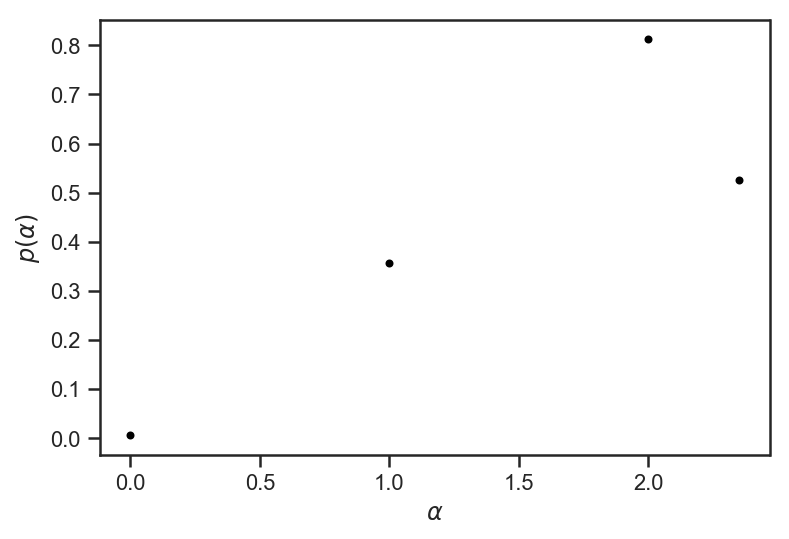

In [53]:
plot(list(logevs.keys()), exp(list(logevs.values())), '.k')

xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \right)$')

Text(0, 0.5, '$p\\left( M \\right)$')

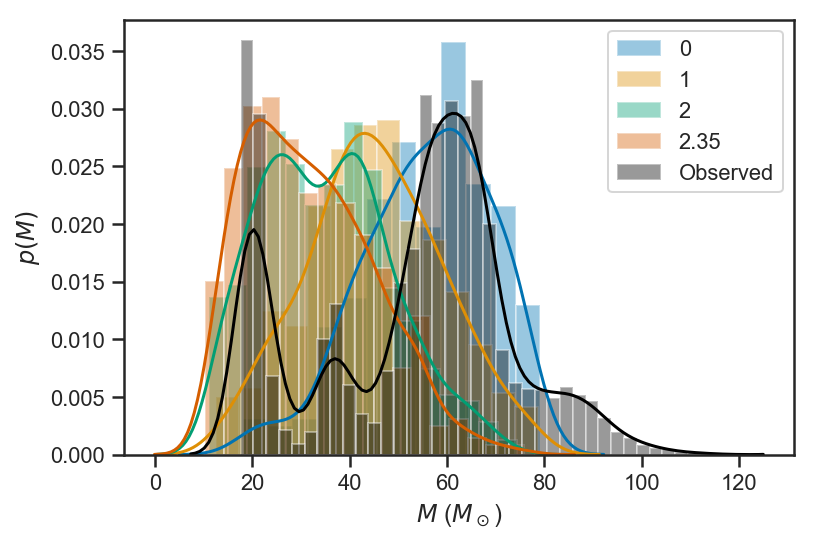

In [55]:
for k, c in clusters.items():
    sns.distplot(c['m1']+c['m2'], label=str(k))
    
ps = []
for _, p in postsamples.items():
    ps.append(random.choice(p[0]+p[1], size=1000))
ps = np.concatenate(ps)
sns.distplot(ps, color='k', label='Observed')

legend(loc='best')
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$p\left( M \right)$')